In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Generate Vehicle Sequence Randomly
def generate_vehicle_sequence(N):

    sequence_length = N

    random_sequence = [random.choice([0, 1]) for _ in range(sequence_length)]

    count_ones = random_sequence.count(1)
    percentage_ones = (count_ones / sequence_length)

    return random_sequence, percentage_ones

In [4]:
def API(list_ = []):

    if not(np.any(list_)):
        return 1
    else:

        result = smt.stattools.acf(list_,adjusted=True)[1]

        return result

In [5]:
def pair_counting(list_=[]):
    L = 1
    pairs = np.zeros([L+1,L+1])
    for i in range(len(list_)-1):
        for j in range(0,L+1):
            for k in range(0, L+1):
                if list_[i] == j and list_[i+1] == k:
                    pairs[j,k] = pairs[j,k]+1

    return pairs

In [6]:
def flow_calculation(n00,n01,n10,n11,h_00,h_01,h_10,h_11):
    q = 3600*(n00+n01+n10+n11)/(h_00*n00+h_01*n01+h_10*n10+h_11*n11)
    return q

In [7]:
def theoretical_flow(h_00,h_10,h_01,h_11,P_CAV,rho):
    q = 3600 / ((1 - P_CAV) * ((rho * P_CAV + 1 - P_CAV) * h_00) + P_CAV * (1 - P_CAV) * (1 - rho) * (h_01 + h_10) + P_CAV * (rho * (1 - P_CAV) + P_CAV) * h_11)
    return q

In [8]:
N = 30

data = pd.DataFrame(columns=['list','N','P','h_00','h_10','h_01','h_11','API','N00','N11','N10','N01','flow_real','flow_theo','error'])

for num in range(0,10001):
    h_00 = random.uniform(0.8, 2.2)
    h_10 = random.uniform(0.8, 2.2)
    h_01 = random.uniform(0.7, 1.5)
    h_11 = random.uniform(0.6, 1.1)
    list_ = generate_vehicle_sequence(N)
    P_CAV = list_[1]
    rho = API(list_[0])
    N00 = pair_counting(list_[0])[0][0]
    N11 = pair_counting(list_[0])[1][1]
    N10 = pair_counting(list_[0])[1][0]
    N01 = pair_counting(list_[0])[0][1]
    q_real = flow_calculation(N00,N01,N10,N11,h_00,h_01,h_10,h_11)
    q_theo = theoretical_flow(h_00,h_10,h_01,h_11,P_CAV,rho)
    error = abs(q_real-q_theo)/q_real

    new_row = {'list':list_,'N':N,'P':P_CAV,'h_00':h_00,'h_10':h_10,'h_01':h_01,'h_11':h_11,'API':rho,'N00':N00,'N11':N11,'N10':N10,'N01':N01,'flow_real':q_real, 'flow_theo':q_theo, 'error':error}
    data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)

In [9]:
data[['error']].astype('float').describe()

,error
count,1.000100e+04
mean,7.795098e-03
std,5.133346e-03
min,9.633571e-07
25%,3.497818e-03
50%,7.238797e-03
75%,1.137171e-02
max,3.213978e-02


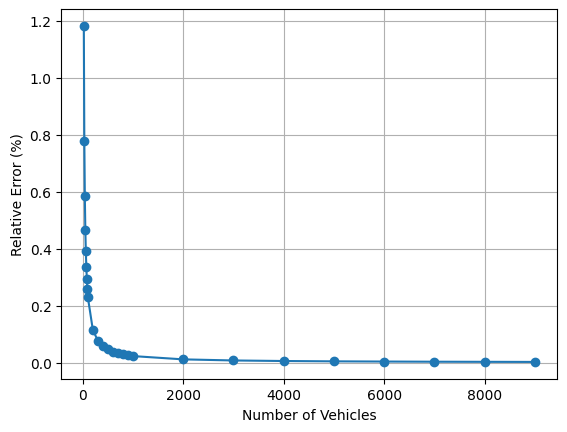

In [10]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool

def compute_error(N):
    errors_for_N = []
    for num in range(0, 10001):
        h_00 = random.uniform(0.8, 2.2)
        h_10 = random.uniform(0.8, 2.2)
        h_01 = random.uniform(0.7, 1.5)
        h_11 = random.uniform(0.6, 1.1)
        list_ = generate_vehicle_sequence(N)
        P_CAV = list_[1]
        rho = API(list_[0])
        N00 = pair_counting(list_[0])[0][0]
        N11 = pair_counting(list_[0])[1][1]
        N10 = pair_counting(list_[0])[1][0]
        N01 = pair_counting(list_[0])[0][1]
        q_real = flow_calculation(N00, N01, N10, N11, h_00, h_01, h_10, h_11)
        q_theo = theoretical_flow(h_00, h_10, h_01, h_11, P_CAV, rho)
        error = abs(q_real - q_theo) / q_real
        errors_for_N.append(error)
    # 计算平均误差
    average_error_for_N = sum(errors_for_N) / len(errors_for_N) * 100
    return N, average_error_for_N

if __name__ == '__main__':
    data = pd.DataFrame(columns=['list', 'N', 'P', 'h_00', 'h_10', 'h_01', 'h_11', 'API', 'N00', 'N11', 'N10', 'N01',
                                 'flow_real', 'flow_theo', 'error'])

    N_values = []
    N_values += list(range(20, 100, 10))
    N_values += list(range(100, 1000, 100))
    N_values += list(range(1000, 10000, 1000))
    average_errors = []

    # 并行计算平均误差
    with Pool(processes=8) as pool:  # 根据你的CPU核心数调整processes参数
        result = pool.map(compute_error, N_values)
        for N, average_error_for_N in result:
            average_errors.append(average_error_for_N)

    # 创建一个包含N和平均误差的DataFrame
    result_data = pd.DataFrame({'N': N_values, 'average_error': average_errors}

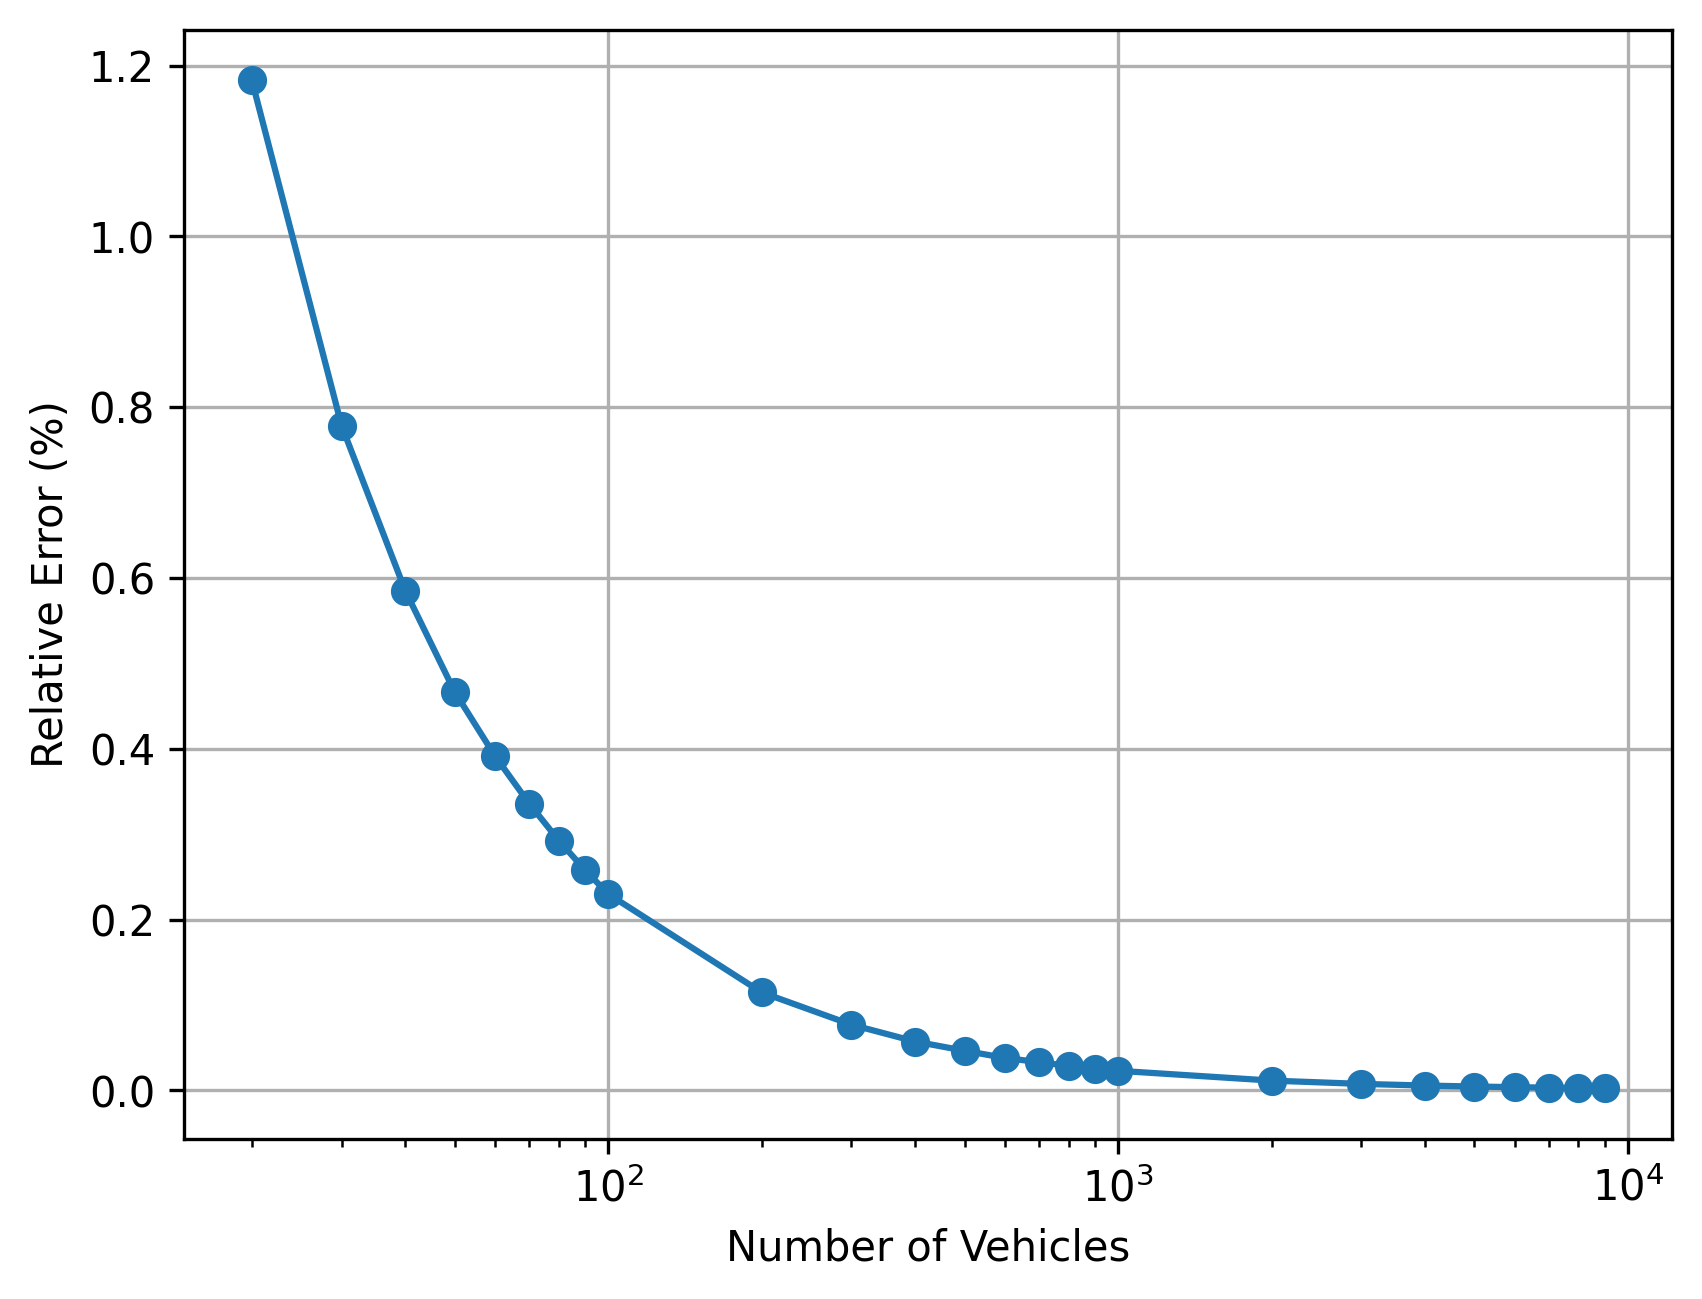

In [12]:
plt.figure(dpi=300)
plt.semilogx(result_data['N'], result_data['average_error'], marker='o')
plt.xlabel('Number of Vehicles')
plt.ylabel('Relative Error (%)')
plt.grid(True)
plt.show()